# Flu Shot Learning

To do
- explore the data
- aoc curve, analysis etc
- explore categoricals with skl
- try many different models
- learning curves
- why AUC and not max difference between curve and linear?

## Load modules and data

In [8]:
# Fundamental
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr as corr

In [9]:
dfx = pd.read_csv('training_set_features.csv')
yall = pd.read_csv('training_set_labels.csv').values[:,1:] # First col = h1n1, second - seasonal.
feats = list()

## Initial (unfitted) preprocessing

In [11]:
dfx['age_group'].unique()

array(['55 - 64 Years', '35 - 44 Years', '18 - 34 Years', '65+ Years',
       '45 - 54 Years'], dtype=object)

In [12]:
def initial_processing(df):
    df['age_num'] = 0
    df.loc[df['age_group'] == '18 - 34 Years','age_num'] = (34-18)/2
    df.loc[df['age_group'] == '35 - 44 Years','age_num'] = (44-35)/2
    df.loc[df['age_group'] == '45 - 54 Years','age_num'] = (54-45)/2
    df.loc[df['age_group'] == '55 - 64 Years','age_num'] = (64-55)/2
    df.loc[df['age_group'] == '65+ Years','age_num']     = 70
    if 'respondent_id' in df.columns:
        df.drop(columns=['respondent_id'],inplace=True)

In [13]:
initial_processing(dfx)

## Data exploration

NameError: name 'feats' is not defined

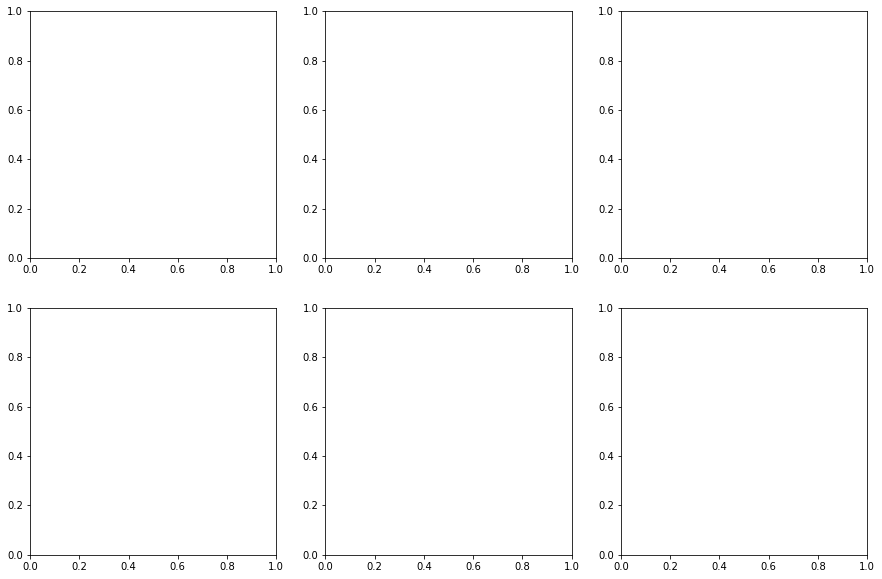

In [14]:
fig, axes = plt.subplots(figsize = (15, 10), ncols=3, nrows=2)
axeslist = [axes[0,i] for i in range(3)] + [axes[1,i] for i in range(3)]

i=0
for thing in feats:
    if 'opinion' in thing:
        dfx[thing].hist(ax = axeslist[i], bins=[0.5,1.5,2.5,3.5,4.5,5.5], grid=False, width=0.8)
        axeslist[i].set_xlabel(thing)
        i+=1
plt.show()

## Create objects for fitted preprocessing

Here we make a function to scale the axes independently, instead of using a transformation pipeline. This is to allow more flexibility when performing feature engineering.

In [ ]:
num_cols = list(dfx.columns[dfx.dtypes != object])
cat_cols = list(dfx.columns[dfx.dtypes == object])

#### Existing transformers
Here we make pipes using built-in transformers.

In [309]:
numerical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

categorical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Custom transformers / pipelines

In [351]:
class WeightedOpinions(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if 'opinion' in col:
                X[col] = (X[col]-3)**3 # 3 is the mid-point. Raise to an odd-power to preserve monotonicity.
        return X
    
extra_processing = Pipeline([
    ('wo', WeightedOpinions()),
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

#### Combine into ColumnTransformer

In [352]:
preprocessor = ColumnTransformer(
    transformers = [
    ('ext', extra_processing, num_cols),
    ('num', numerical_processing, num_cols),
    ('cat', categorical_processing, cat_cols)
    ], 
    remainder='drop')

## Define models

In [360]:
global_max_iter = 600

model_logreg_l1 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=global_max_iter)
)

model_logreg_l2 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=global_max_iter)
)

model_logreg_elastic = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=global_max_iter, l1_ratio = 0.5)
)

model_rf01 = MultiOutputClassifier(
    estimator=RandomForestClassifier()
)


#XX What is C?

dict_of_models = {
    'logred_l1':model_logreg_l1,
    'logred_l2':model_logreg_l2,
    'logreg_elastic':model_logreg_elastic,
    'rf01':model_rf01,
}

## Define output translation functions

In [346]:
def transform_MOC_output(arrin):
    h1n1_probs = arrin[0][:,1]
    seas_probs = arrin[1][:,1]
    return np.stack([h1n1_probs, seas_probs]).T

## Create train/test split

In [7]:
dfxtr, dfxcv, ytr, ycv = train_test_split(
    dfx,
    yall,
    test_size=0.33,
    shuffle=True,
    stratify=yall,
    random_state=6
)

## Fit and test models

In [353]:
xtr = preprocessor.fit_transform(dfxtr)
xcv = preprocessor.transform(dfxcv)

In [368]:
models_to_test = dict_of_models.keys() # Can change to a subset

In [369]:
for modelname in models_to_test:
    model = dict_of_models[modelname]
    model.fit(xtr, ytr);
    print('Model {} fit complete'.format(modelname))

Model logred_l1 fit complete
Model logred_l2 fit complete
Model logreg_elastic fit complete


/Users/Scott/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Scott/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model rf01 fit complete


In [370]:
dict_of_ypr = {}
dict_of_auc = {}

for modelname in models_to_test:
    model = dict_of_models[modelname]
    ypr = transform_MOC_output(model.predict_proba(xcv))
    dict_of_ypr[modelname] = ypr
    dict_of_auc[modelname] = roc_auc_score(ycv, ypr)

In [371]:
[(x, dict_of_auc[x]) for x in sorted(dict_of_auc)]

[('logred_l1', 0.8457386324723919),
 ('logred_l2', 0.8456195466077017),
 ('logreg_elastic', 0.8457178020021137),
 ('rf01', 0.8010941751261782)]

In [205]:
def plot_roc(dict_of_ypr, label):
    def subroutine(y_true, y_score, label_name, ax):
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_ylabel('TPR')
        ax.set_xlabel('FPR')
        ax.set_title(
            f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
        )

    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    ypr = dict_of_ypr[label]
    
    subroutine(
        ycv[:,0], 
        ypr[:,0], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    subroutine(
        ycv[:,1], 
        ypr[:,1], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    return None

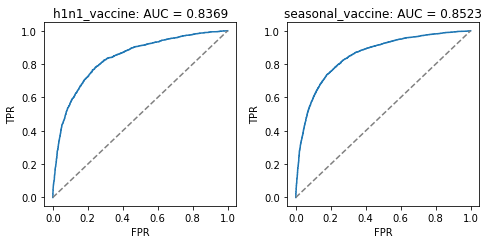

In [206]:
plot_roc(dict_of_ypr,'logred_l2')

## Produce labels for submission

In [390]:
df_test = pd.read_csv('test_set_features.csv')
sub_format = pd.read_csv('submission_format.csv',index_col='respondent_id')

In [391]:
initial_processing(df_test)
xte = preprocessor.transform(df_test)
ytepr = transform_MOC_output(model_logreg_l1.predict_proba(xte))

In [392]:
ytepr

array([[0.06095041, 0.2810212 ],
       [0.04236911, 0.03446331],
       [0.35404326, 0.61019757],
       ...,
       [0.13912457, 0.18165487],
       [0.089318  , 0.31684846],
       [0.3678146 , 0.38753825]])

In [393]:
sub_format['h1n1_vaccine'] = ytepr[:,0]
sub_format['seasonal_vaccine'] = ytepr[:,1]

In [395]:
sub_format.to_csv('flu_sub_070520_01.csv', index=True)

In [396]:
!head flu_sub_070520_01.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.060950411174664244,0.2810212043844564
26708,0.042369108446963816,0.034463307209025164
26709,0.35404326030740996,0.6101975706864255
26710,0.4073845857829163,0.84140843637834
26711,0.199337693004797,0.3917508425517273
26712,0.45276797575149613,0.9379460708665571
26713,0.3809567745165908,0.5778227461759351
26714,0.1363375635215883,0.20617041411859013
26715,0.05968877173348687,0.19057195110617084
